In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../datasets/ready_to_work_try1.csv', low_memory=False)

In [3]:
pd.set_option('display.max_colwidth', None)
df.head(1)
#номер строки 
#идентификатор новости
#оригинальный текст
#текст после чистки
#текст после обработки PyMystem3

,Unnamed: 0,user_id,telegram_id,text,title,text_clean
0,21944,22078,128182,"путин: россия будет форсировать массовый выпуск бпла, хорошо зарекомендовавших себя в боевых условиях.","путин: россия будет форсировать массовый выпуск бпла, хорошо зарекомендовавших себя в боевых условиях.","['путин', 'россия', 'форсировать', 'массовый', 'выпуск', 'бпла', 'зарекомендовавших', 'боевых', 'условиях', '']"


In [45]:
#df.info()

In [4]:
work_df = df.drop(['telegram_id', 'Unnamed: 0', 'user_id', 'title'], axis=1)

In [5]:
work_df.head(1)

,text,text_clean
0,"путин: россия будет форсировать массовый выпуск бпла, хорошо зарекомендовавших себя в боевых условиях.","['путин', 'россия', 'форсировать', 'массовый', 'выпуск', 'бпла', 'зарекомендовавших', 'боевых', 'условиях', '']"


In [6]:
print('количество новостей для теста:', work_df.shape[0])

количество новостей для теста: 764


In [8]:
# дублирую просто чтобы проверить как работает поиск дубликатов
#work_df = pd.concat([work_df, work_df])
#print('количество новостей для теста:', work_df.shape[0])

In [7]:
print('количество новостей для теста:', work_df.shape)
work_df.info()

количество новостей для теста: (764, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        764 non-null    object
 1   text_clean  764 non-null    object
dtypes: object(2)
memory usage: 12.1+ KB


In [88]:
#ОККККККККК

In [89]:
#случайным образом выбираем 30 % новостей
#df_percent = work_df.sample(frac=0.1)

In [8]:
#давай склепаем tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [9]:
#vectorizer = TfidfVectorizer(stop_words=russian_stopwords)
vectorizer = TfidfVectorizer()
Tf_Idf = vectorizer.fit_transform(work_df['text_clean'].values.astype('U'))
#Tf_Idf = vectorizer.fit_transform(df_percent['text_clean'])

In [10]:
#количество новостей, количество слов
Tf_Idf.shape

(764, 14361)

In [11]:
cosine_sim = linear_kernel(Tf_Idf, Tf_Idf)
cosine_sim.shape

(764, 764)

In [12]:
def get_duplicates(text_news, title, cosine_sim, top_k=10):
    indices = pd.Series(text_news.index)
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:top_k + 1]
    text_indices = [i[0] for i in sim_scores]
    return list(text_news['text_clean'].iloc[text_indices])
print('Топ-10 новостей по описанию',
      *get_duplicates(work_df, title=54, cosine_sim=cosine_sim, top_k=10), sep='\n, \n')

Топ-10 новостей по описанию
, 
['', 'путин', 'курс', 'открытость', 'экономики', 'наш', 'важнейший', 'принцип', 'речьпутина']
, 
['перспективы', 'российской', 'экономики', 'горизонте', 'лет', 'будут', 'определяться', 'разрешением', 'пяти', 'противоречий', 'считает', 'экономист', 'цмакпа', 'дмитрий', 'белоусов', 'узловые', 'противоречия', 'эксперт', 'увидел', 'ситуации', 'рынке', 'труда', 'внешнеторговой', 'политике', 'социальной', 'сфере', 'логике', 'функционирования', 'экономики', 'числе', 'невозможность', 'роботозамещения', 'рабочих', 'усиление', 'плановости']
, 
['', 'боевые', 'п', 'орасы', 'наш', 'основной', 'курс', 'месяцев', 'готовит', 'настоящих', 'бойцов', 'профессиональных', 'программистов', 'месяцев', 'каждый', 'готовы', 'прыгнуть', 'встречу', 'приключениям', 'новую', 'профессию', 'первым', 'результатом', 'год', 'начала', 'обучения', 'летом', 'хочу', 'провести', 'сокращённый', 'курс', 'котором', 'дам', 'первый', 'результат', 'месяц', 'обучения', 'например', 'сделаете', 'первую

In [54]:
#df.to_csv('../datasets/cosine_sim.csv')

In [13]:
from sklearn.cluster import KMeans

In [21]:
#количество категорий, подумаем еще) 
k = 40

In [22]:
model = KMeans(
    n_clusters=k,
    init='k-means++',
    max_iter=100,
    n_init=1)
#потренируем модель на Tf-Idf
model.fit(cosine_sim)

KMeans(max_iter=100, n_clusters=40, n_init=1)

In [23]:
labels = model.labels_
#создаем датафрейм, который содержит кластеры, по категориям
mapping = list(zip(labels, work_df.index, work_df['text']))
clusters = pd.DataFrame(mapping, columns = ['cluster', 'ID','text'])
clusters.head()

,cluster,ID,text
0,5,0,"путин: россия будет форсировать массовый выпуск бпла, хорошо зарекомендовавших себя в боевых условиях."
1,39,1,"❗️предпосылок для разрешения ситуации на украине политико-дипломатическим путем нет, поэтому сво продолжается — песков\n\n[петя первый. подписаться](https://t.me/petya_perviy)"
2,15,2,"**""نيوزويك"": روسيا كشفت إحدى نقاط الضعف الرئيسية بالقوات الأوكرانية **\n\n قالت مجلة ""نيوزويك""، إنه لم يتبق لدى الغرب عمليا أي كمية من منظومات الدفاع الجوي المحمولة من طراز ستينغر لإرسالها إلى القوات الأوكرانية، مما يؤثر بشكل جدي على قدراتها القتالية. \n\n👈 [المزيد من التفاصيل](https://rtarabic.com/world/1474915-نيوزويك-روسيا-كشفت-أحد-نقاط-الضعف-الرئيسية-بالقوات-الأوكرانية/?utm_source=telegram&utm_medium=telegram&utm_campaign=telegram)\n\n[ subscribe | انضم إلينا 🤝](https://t.me/rtarabictelegram)"
3,15,3,обстановка в ницце.\n\n[петя первый. подписаться](https://t.me/petya_perviy)
4,31,4,"сообщение об ограничениях в обороте юаней, которые заработали российские субъекты, неизбежно дополняются вопросом о стратегии торговли за неконвертируемые валюты «дружественных» стран. нужно понимать, что между «дружественной» и «недружественной» страной расстояние весьма небольшое и условное. сегодня руси-инди бхай-бхай, завтра - ножи в спину. тут нет гарантий.\n\nтем не менее вопрос: что делать с растущим количеством в сущности, ненужных рупий, юаней, дирхамов, лир и прочих тугриков - он, конечно, встает.\n\nможно сколько угодно рассказывать про дедолларизацию и крах доллара буквально завтра, но ни одна мировая валюта не предлагает такой список удобств расчетов. доллар универсален, причем настолько, что это создает ряд сложностей - им очень охотно пользуется международная транснациональная преступность и прочие периферийные нувориши вроде наших воришек. кто слышал о наркокартелях, работающих за юани или рупии? дураков нет.\n\nсамое смешное, что даже перейдя на «торговлю в национальных валютах», ее объемы все равно измеряют в тех же неблагодатных долларах - а в чем еще измерять-то? в камушках и стекляшечках?\n\nно жить можно даже в таких условиях. однако для этого требуется, чтобы российские структуры озаботились заключением межправительственных соглашений с той же индией или китаем - вложить эти рупии и юани непосредственно в стране происхождения. открыть курорты, купить и построить заводы, вложить в технологические стартапы.\n\nминистерству иностранных дел нужно не геев ловить на западе и не «калинку» отплясывать в пьяном угаре, а не вылазить из индии, китая, оаэ - и пристраивать там заработанные рупии, юани, дирхамы. в противном случае можно однозначно сказать, что их ожидает судьба всех предыдущих безвозвратных кредитов - их банально спишут. как списали кубе тридцать с лишним миллиардов долларов вместо того, чтобы на эти деньги открыть там всероссийские здравницы, к примеру. или тем же африканцам - суммы списаний приближаются к сотням миллиардов долларов, и что от них получила страна?\n\nно всё это сложно и неинтересно. гораздо проще заклеймить очередного врага и поржать над запнувшимся байденом - для этого ума много не надо, а рабочее время идёт."


In [24]:
clusters['cluster'].value_counts()

#ch_nan = clusters['text_lemma'].isnull().values.any()
#print(ch_nan)

cluster
15    156
31     42
8      32
28     32
7      29
24     28
18     28
34     28
1      28
23     26
39     21
5      21
10     19
4      18
36     17
0      17
6      17
25     17
35     16
12     15
14     13
16     12
17     12
26     12
38     12
22     11
32     11
2      10
19      9
30      8
20      8
11      7
3       7
33      5
29      4
37      4
9       4
21      3
27      3
13      2
Name: count, dtype: int64

In [27]:
clusters[(clusters['cluster'] == 21)]

,cluster,ID,text
326,21,326,путин сделает ряд важных заявлений сегодня вечером — песков.
421,21,421,"⚡️президент россии владимир путин сделает ряд важных заявлений вечером 26 июня, сообщил официальный представитель кремля дмитрий песков."
451,21,451,"дмитрий песков анонсировал «ряд важных заявлений» путина сегодня вечером\n\nдругие детали пресс-секретарь президента рф не уточнил, как и время выступления путина. \n#россия\n\n✅[подпишись на @asiaplus](https://t.me/asiaplus)"


In [31]:
marked_data = clusters

In [34]:
marked_data = marked_data['cluster'].replace('21', 'Politics')

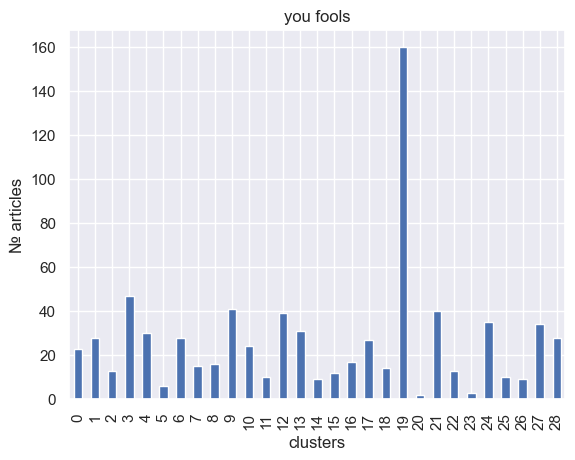

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

clusters.cluster.value_counts().sort_index().plot(kind='bar')
plt.xlabel('clusters')
plt.ylabel('№ articles')
plt.title('you fools')
plt.show()

In [38]:
#находим парочки слов
def find_bigrams (input_list):
    return list(zip(input_list, input_list[1:]))

In [39]:
from collections import Counter 
from nltk.tokenize import word_tokenize

In [64]:
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

In [65]:
#удаляю русские стоп слова (расширить???)
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

In [29]:
#нужно ли, если корректно работает токенизатор? 
#stopwords =  pd.read_csv('../datasets/stop_words_russian.txt', low_memory=False)

In [40]:
my_dict = {}
n_clusters = clusters['cluster'].unique()
for c in n_clusters:
    asset = clusters[clusters['cluster'] == c]
    words = asset ['text_lemma']
    bigrams = find_bigrams(words)
    bigrams = list(map(' '.join, bigrams))
    counts = Counter(bigrams)
    most_common = counts.most_common(4)
    most_freq = [bigram[0] for bigram in most_common]
    my_dict[c] = ','.join(most_freq)
my_dict

TypeError: sequence item 1: expected str instance, float found

In [41]:
#надо бы как то кластеры обозвать?
val_count = clusters['cluster'].value_counts()
for i in range (len(val_count)):
    my_dict[i] += f'({val_count[i]})'

KeyError: 0

In [72]:
my_dict

{22: "['ещё', 'фото', 'видео', 'грета', 'тунберг', 'киев', 'экоактивистка', 'ехать', 'киев', 'поезд', 'вид', 'дальний', 'путешествие', 'известно', 'признать', 'сегодня', 'банковый', 'встретиться', 'зеленский'] ['хороший', 'сказать'],['хороший', 'сказать'] ['июль', 'россия', 'действовать', 'акциз', 'сахаросодержащий', 'напиток', 'ставка', 'безалкогольный', 'напиток', 'добавление', 'сахар', 'иной', 'подслащивать', 'вещество', 'свыше', 'мл', 'составлять', 'рубль', 'литр', 'акциз', 'подпадать', 'сок', 'нектар', 'сокосодержать', 'напиток', 'морс', 'алкоголь', 'rozetked', 'подписаться'],['июль', 'россия', 'действовать', 'акциз', 'сахаросодержащий', 'напиток', 'ставка', 'безалкогольный', 'напиток', 'добавление', 'сахар', 'иной', 'подслащивать', 'вещество', 'свыше', 'мл', 'составлять', 'рубль', 'литр', 'акциз', 'подпадать', 'сок', 'нектар', 'сокосодержать', 'напиток', 'морс', 'алкоголь', 'rozetked', 'подписаться'] ['приходить', 'силовик', 'колдовство', 'переставать', 'работать', 'битва', 'экст

In [19]:
from sklearn.decomposition import PCA
# https://www.jcchouinard.com/pca-with-python/ 
# Dimensionality reduction
# Reduce features to 2D
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(Tf_Idf.toarray())
 
# Reduce centroids to 2D
#reduced_centroids = pca.transform(model.cluster_centers_)
 
print('Tf-IDF feature size: ', Tf_Idf.toarray().shape)
print('PCA feature size: ', reduced_features.shape)
#print('Tf-IDF cluster centroids size: ', model.cluster_centers_.shape)
#print('PCA centroids size: ', reduced_centroids.shape)


Tf-IDF feature size:  (7644, 34974)
PCA feature size:  (7644, 2)


In [ ]:
#предсказываем кластеры
prediction = model.predict(Tf_Idf)
prediction

In [75]:
print('количество статей', len(prediction))
print('количество предсказанных кластеров', len(np.unique(prediction)))

NameError: name 'prediction' is not defined

In [38]:
#метки для графика
labels = np.vectorize(my_dict.get)(prediction)

In [39]:
import matplotlib.pyplot as plt

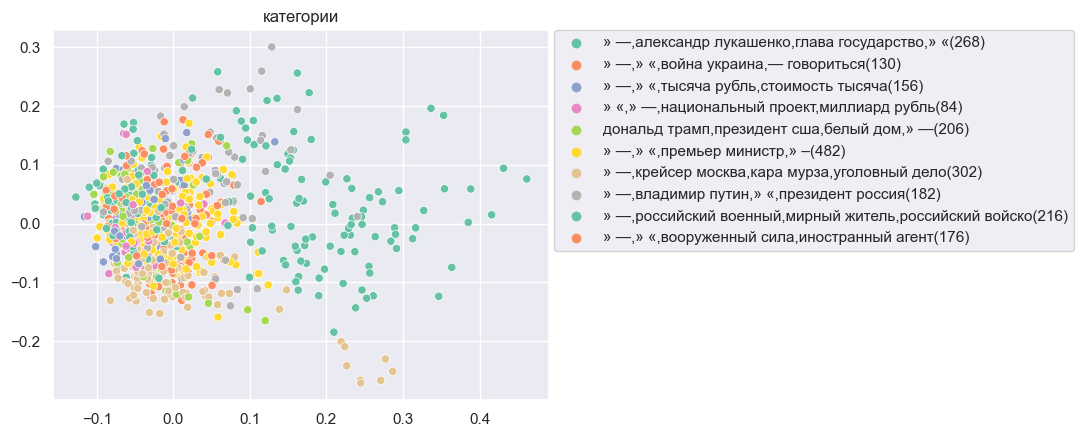

In [42]:
#проверим на графике как это выглядит 
#группировка статей
sns.scatterplot(
    x = reduced_features[:,0], 
    y = reduced_features[:,1],
    hue = labels, 
    palette = 'Set2')

#центры кластеров
#plt.scatter(
   # reduced_features[:,0], 
    #reduced_features[:,1],
    #marker = 'x',
   # s = 150, 
  #  c = 'k')

#график 
plt.legend(bbox_to_anchor = (1.01, 1),
         borderaxespad = 0)
plt.title('категории')
plt.show()